<a href="https://colab.research.google.com/github/amanu242006/FAC-task-3/blob/main/FAC_Task_3_team_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Subfolders found: ['01Jan-Nifty', '02Feb-Nifty', '03Mar-Nifty', '04Apr-Nifty', '05May-Nifty', '06June-Nifty', '07July-Nifty', '08Aug-Nifty', '09Sept-Nifty', '10Oct-Nifty', '11Nov-Nifty', '12Dec-Nifty']

Processing: 01Jan-Nifty

Processing: 02Feb-Nifty

Processing: 03Mar-Nifty

Processing: 04Apr-Nifty

Processing: 05May-Nifty

Processing: 06June-Nifty
⚠️ Skipping file /content/drive/MyDrive/OptionBacktest2023/06June-Nifty/18200_call_2023-06-29.json due to error: If using all scalar values, you must pass an index
⚠️ Skipping file /content/drive/MyDrive/OptionBacktest2023/06June-Nifty/18200_put_2023-06-29.csv due to error: No columns to parse from file

Processing: 07July-Nifty

Processing: 08Aug-Nifty

Processing: 09Sept-Nifty

Processing: 10Oct-Nifty

Processing: 11Nov-Nifty

Processing: 12Dec-Nifty

Summary Report
Total Trades: 2775
Winning Trades: 1237
Losin

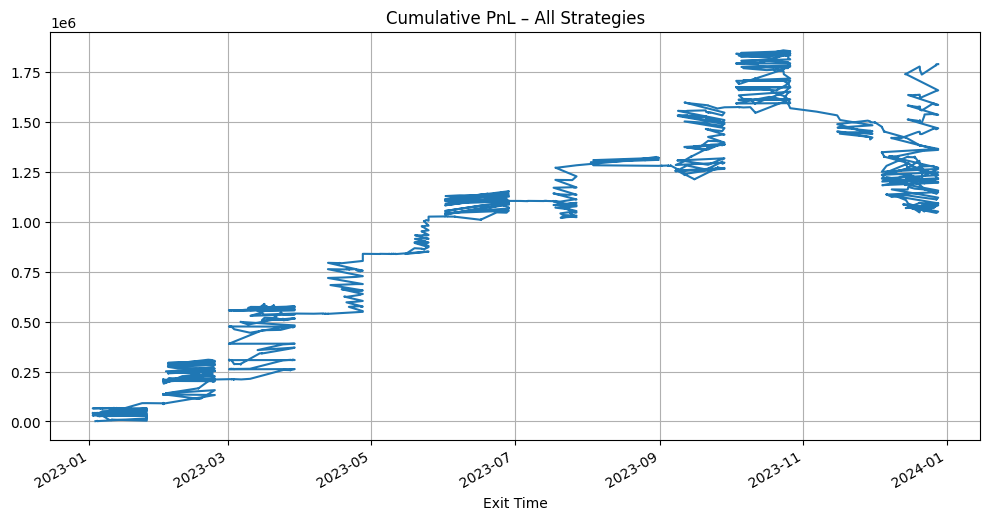

In [7]:


# Step 1: Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Imports
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Step 3: Paths
spot_path = "/content/drive/MyDrive/OptionBacktest2023/NIFTY2023/NIFTY_cash.csv"
option_base_path = "/content/drive/MyDrive/OptionBacktest2023"

# Step 4: Spot Data
spot_df = pd.read_csv(spot_path, parse_dates=["datetime"])
spot_df = spot_df[["datetime", "close"]].rename(columns={"close": "spot_price"})
spot_df["spot_price"] = pd.to_numeric(spot_df["spot_price"], errors="coerce")

# Step 5: Extract expiry from file names
def extract_expiry(folder):
    call_files = glob.glob(os.path.join(folder, "*_call_*.json"))
    for f in call_files:
        match = re.search(r'(\d{4}-\d{2}-\d{2})', f)
        if match:
            return pd.to_datetime(match.group(1))
    return None

# Step 6: Strategy Function
def run_strategy(df, expiry_date, sl_pct=0.25, tp_pct=0.5, atr_threshold=2):
    trades = []
    position = None
    entry_price = None
    entry_time = None
    position_type = None

    for i in range(1, len(df)):
        row = df.iloc[i]
        current_time = row.name
        spot = row['spot_price']

        if row['ATR'] < atr_threshold:
            continue

        atm_strike = row['strike']
        otm_call_strike = atm_strike + 200
        otm_put_strike = atm_strike - 200
        deep_otm_call_strike = atm_strike + 400
        deep_otm_put_strike = atm_strike - 400

        straddle_premium = row['call_price'] + row['put_price']

        def get_price(strike, col):
            match = df.loc[(df.index == current_time) & (df['strike'] == strike)]
            return pd.to_numeric(match[col].values[0], errors='coerce') if not match.empty else None

        strangle_premium = None
        call_otm = get_price(otm_call_strike, 'call_price')
        put_otm = get_price(otm_put_strike, 'put_price')
        if call_otm is not None and put_otm is not None:
            strangle_premium = call_otm + put_otm

        butterfly_call_debit = butterfly_put_debit = None
        short_butterfly_call_credit = short_butterfly_put_credit = None
        ratio_call_debit = ratio_put_debit = None

        atm_call = row['call_price']
        atm_put = row['put_price']

        otm_call = call_otm
        otm_put = put_otm
        deep_otm_call = get_price(deep_otm_call_strike, 'call_price')
        deep_otm_put = get_price(deep_otm_put_strike, 'put_price')

        if otm_call and deep_otm_call:
            butterfly_call_debit = deep_otm_call + atm_call - 2 * otm_call
            short_butterfly_call_credit = 2 * otm_call - (deep_otm_call + atm_call)
            ratio_call_debit = atm_call - 2 * otm_call

        if otm_put and deep_otm_put:
            butterfly_put_debit = deep_otm_put + atm_put - 2 * otm_put
            short_butterfly_put_credit = 2 * otm_put - (deep_otm_put + atm_put)
            ratio_put_debit = atm_put - 2 * otm_put

        if position:
            current_premium = {
                "straddle": straddle_premium,
                "strangle": strangle_premium,
                "long_call_butterfly": butterfly_call_debit,
                "long_put_butterfly": butterfly_put_debit,
                "short_call_butterfly": short_butterfly_call_credit,
                "short_put_butterfly": short_butterfly_put_credit,
                "ratio_call_spread": ratio_call_debit,
                "ratio_put_spread": ratio_put_debit
            }.get(position_type, straddle_premium)

            if current_premium is None or entry_price is None:
                continue

            exit_due_to_sl_tp = (
                position == "long" and (current_premium >= entry_price * (1 + tp_pct) or current_premium <= entry_price * (1 - sl_pct))
            ) or (
                position == "short" and (current_premium <= entry_price * (1 - tp_pct) or current_premium >= entry_price * (1 + sl_pct))
            )
            force_exit = current_time.date() >= expiry_date.date()

            if exit_due_to_sl_tp or force_exit:
                pnl = ((current_premium - entry_price) if position == "long" else (entry_price - current_premium)) * 100
                trades.append({
                    "Entry Time": entry_time,
                    "Exit Time": current_time,
                    "Position": position,
                    "Strategy": position_type,
                    "Strike": atm_strike,
                    "Entry Price": entry_price,
                    "Exit Price": current_premium,
                    "PnL": pnl,
                    "Forced Exit": force_exit
                })
                position = None

        if not position and current_time.date() < expiry_date.date():
            if spot > row['Upper_Band'] and strangle_premium:
                position = "long"
                entry_price = strangle_premium
                entry_time = current_time
                position_type = "strangle"
            elif spot < row['Lower_Band']:
                position = "short"
                entry_price = straddle_premium
                entry_time = current_time
                position_type = "straddle"
            elif butterfly_call_debit:
                position = "long"
                entry_price = butterfly_call_debit
                entry_time = current_time
                position_type = "long_call_butterfly"
            elif butterfly_put_debit:
                position = "long"
                entry_price = butterfly_put_debit
                entry_time = current_time
                position_type = "long_put_butterfly"
            elif short_butterfly_call_credit:
                position = "short"
                entry_price = short_butterfly_call_credit
                entry_time = current_time
                position_type = "short_call_butterfly"
            elif short_butterfly_put_credit:
                position = "short"
                entry_price = short_butterfly_put_credit
                entry_time = current_time
                position_type = "short_put_butterfly"
            elif ratio_call_debit:
                position = "long"
                entry_price = ratio_call_debit
                entry_time = current_time
                position_type = "ratio_call_spread"
            elif ratio_put_debit:
                position = "long"
                entry_price = ratio_put_debit
                entry_time = current_time
                position_type = "ratio_put_spread"

    return pd.DataFrame(trades)

# Step 7: Backtest
all_trades = []
folders = sorted([f.path for f in os.scandir(option_base_path) if f.is_dir() and "NIFTY2023" not in f.name])
print("Subfolders found:", [os.path.basename(f) for f in folders])

for folder in folders:
    print(f"\nProcessing: {os.path.basename(folder)}")
    expiry = extract_expiry(folder)
    if expiry is None:
        continue

    call_files = glob.glob(os.path.join(folder, "*_call_*.json"))
    put_files = glob.glob(os.path.join(folder, "*_put_*.csv"))
    all_calls, all_puts = [], []

    for cf in call_files:
        try:
            raw = pd.read_json(cf)
            if "Success" not in raw:
                print(f" Skipping file (missing 'Success'): {cf}")
                continue
            df = pd.DataFrame(raw["Success"].tolist())
        except Exception as e:
            print(f" Skipping file {cf} due to error: {e}")
            continue

        df = df[["datetime", "close"]].rename(columns={"close": "call_price"})
        df["datetime"] = pd.to_datetime(df["datetime"])
        df["strike"] = int(re.search(r'(\d+)_call_', cf).group(1))
        all_calls.append(df)

    for pf in put_files:
        try:
            df = pd.read_csv(pf, parse_dates=["datetime"])
            df = df[["datetime", "close"]].rename(columns={"close": "put_price"})
            df["strike"] = int(re.search(r'(\d+)_put_', pf).group(1))
            all_puts.append(df)
        except Exception as e:
            print(f" Skipping file {pf} due to error: {e}")
            continue

    if not all_calls or not all_puts:
        continue

    call_df = pd.concat(all_calls)
    put_df = pd.concat(all_puts)
    df = pd.merge(call_df, put_df, on=["datetime", "strike"], how="inner")
    df = pd.merge(df, spot_df, on="datetime", how="inner")
    df.dropna(inplace=True)

    df["call_price"] = pd.to_numeric(df["call_price"], errors="coerce")
    df["put_price"] = pd.to_numeric(df["put_price"], errors="coerce")
    df["spot_price"] = pd.to_numeric(df["spot_price"], errors="coerce")

    df.set_index("datetime", inplace=True)
    df['H-L'] = df['spot_price'].diff().abs()
    df['ATR'] = df['H-L'].rolling(window=14).mean()
    df['MA'] = df['spot_price'].rolling(window=20).mean()
    df['STD'] = df['spot_price'].rolling(window=20).std()
    df['Upper_Band'] = df['MA'] + 2 * df['STD']
    df['Lower_Band'] = df['MA'] - 2 * df['STD']

    trades = run_strategy(df, expiry)
    if not trades.empty:
        trades["Month"] = os.path.basename(folder)
        all_trades.append(trades)

# Step 8: Summary
if all_trades:
    results = pd.concat(all_trades)
    results["Cumulative PnL"] = results["PnL"].cumsum()

    print("\nSummary Report")
    print("Total Trades:", len(results))
    print("Winning Trades:", len(results[results['PnL'] > 0]))
    print("Losing Trades:", len(results[results['PnL'] < 0]))
    print("Average PnL:", round(results["PnL"].mean(), 2))
    print("Net PnL:", round(results["PnL"].sum(), 2))
    print("Trades by Month:\n", results["Month"].value_counts())
    print("Strategy Breakdown:\n", results["Strategy"].value_counts())
    print("PNL by Strategy:\n", results.groupby("Strategy")["PnL"].sum().sort_values(ascending=False))

    results.set_index("Exit Time")["Cumulative PnL"].plot(figsize=(12, 6), title="Cumulative PnL – All Strategies")
    plt.grid(True)
    plt.show()
else:
    print("No trades executed.")



